In [107]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math

In [108]:
data_path = 'ab_stats.csv'
data = pd.read_csv(data_path)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (23652, 5)


,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727


<div class="alert alert-info">
1) Подведите результаты эксперимента в экселе по следующим данным: ab_stats.csv - Google Диск: Стат значимо ли отличается ARPPU в двух группах ? Какие рекомендации дадите менеджеру?
</div>

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [69]:
group_A = data.loc[(data['ab_group'] == 'A') & (data['purchase'] == 1), ['revenue']]
group_B = data.loc[(data['ab_group'] == 'B') & (data['purchase'] == 1), ['revenue']]
group_A.head()

,revenue
45,1.885595
54,1.002159
82,2.990000
104,49.990000
110,22.093757


In [110]:
t_stat, p_value = stats.ttest_ind(group_A['revenue'], group_B['revenue'])

In [111]:
print(f"Покупки:")
print(f"t-stat: {t_stat:.2f}, p_value: {p_value:.4f}")
if p_value < 0.05:
    print("Различие значимо: группа B показала лучшие покупки")
else:
    print("Различие незначимо: уровень покупок не особо изменился")

Покупки:
t-stat: 1.08, p_value: 0.2788
Различие незначимо: уровень покупок не особо изменился


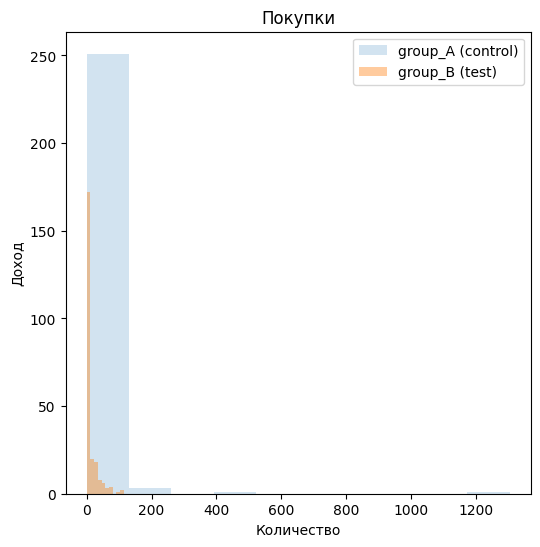

In [112]:
plt.figure(figsize=(6, 6))
plt.hist(group_A['revenue'], alpha=0.2, label='group_A (control)')
plt.hist(group_B['revenue'], alpha=0.4, label='group_B (test)')
plt.title("Покупки")
plt.xlabel("Количество")
plt.ylabel("Доход")
plt.legend()

<div class="alert alert-success">
Вывод:
t-stat: 1.08, p_value: 0.2788<br>
Различие незначимо: уровень покупок не особо изменился.<br>
Но нулевую гипотезу не отклоняем, можно провести еще дополнительные тесты или применить другие стат.методы
</div>


<div class="alert alert-info">
2) Мы хотим провести А/Б-тест для трех источников трафика.<br>
Нынешняя конверсия равна 5%, мы ожидаем прирост в 0,2%.<br>
Уровень доверия 97% и уровень мощности 87%.<br>
Всего на наш продукт заходит 40 000 пользователей в месяц.<br>
За сколько дней мы сможем протестировать гипотезу?<br>
</div>

In [113]:
BCR = 0.05
MDE = 0.052
alpha = 0.03
beta = 0.13
month_users = 40000

def find_n(pa, p0, alpha, beta):
    za = stats.norm().ppf(1 - alpha / 2)
    zb = stats.norm().ppf(1 - beta)
    sn = (np.sqrt(p0 * (1 - p0)) * za + np.sqrt(pa * (1 - pa)) * zb) / (pa - p0)
    return sn ** 2

# Находим к-во пользователей для теста для каждой группы
every_group_users = find_n(BCR, MDE, alpha, beta)
print(f'Количество пользователей в каждой группе: {every_group_users:.0f}')

# Находим к-во пользователей в день
day_users = month_users / 30

# Находим к-во необходимых для теста дней (к-во для каждой группы умножаем на 3, чтобы юзеры не пересекались)
days_for_test = every_group_users * 3 / day_users
print(f'Количество дней для теста: {days_for_test:.0f}')

Количество пользователей в каждой группе: 132245
Количество дней для теста: 298


<div class="alert alert-info">
И что вы можете посоветовать по результатам подсчета?
</div>

<div class="alert alert-success">
Такой долгий тест - возможно, нерентабелен, а также за такой время могут повлиять другие факторы.<br>
По возможности - лучше отказаться от 3 группы в тесте, или воспользоваться другими методами.
</div>

<div class="alert alert-info">
3) Допустим в задаче нет проблемы с количеством посетителей на сайт,<br>
тогда подведите результаты тестирования, если у нас следующие результаты по количеству конверсии:<br>
1) 25 000<br>
2) 30 000<br>
3) 32 000<br>
</div>

In [118]:
new_conversions = [25000, 30000, 32000]

def A_B_test(_bcr, _conversion, _month_users, _alpha):
    p1 = _bcr
    p2 = _conversion / _month_users
    std1 = math.sqrt(p1 * (1 - p1) / _month_users)
    std2 = math.sqrt(p2 * (1 - p2) / _month_users)
    z_stat = (p2 - p1) / math.sqrt(std1 ** 2 + std2 ** 2)
    _p_value = 1 - stats.norm.cdf(z_stat)
    return _p_value

for conversion in new_conversions:
    days_for_test = every_group_users * 3 / (conversion / BCR / 30)
    test_result = False
    print(f'Количество дней для теста при конверсии {conversion}: {days_for_test:.0f}')
    
    p_value = A_B_test(BCR, conversion, month_users, alpha)
    if p_value < alpha:
        print(f'p_value = {p_value}, Статистическая значимость результата теста: Значимо')
    else:
        print(f'p_value = {p_value}, Статистическая значимость результата теста: Не значимо')

Количество дней для теста при конверсии 25000: 24
p_value = 0.0, Статистическая значимость результата теста: Значимо
Количество дней для теста при конверсии 30000: 20
p_value = 0.0, Статистическая значимость результата теста: Значимо
Количество дней для теста при конверсии 32000: 19
p_value = 0.0, Статистическая значимость результата теста: Значимо


<div class="alert alert-success">
При таком трафике - дительность тестов будет намного меньше.<br>
p-value показывает на то, что статистическая значимость всех 3 результатов велика.
</div>

<div class="alert alert-info">
4) Вы решили сравнивать метрику CPA в двух группах.<br>
Размер выборки - 2350 элементов в каждой группе.<br>
Для проверки нормальности распределения на выборке в 2350 наблюдений применили <br>
критерий Шапиро-Уилка и получили p-value, равный 0.00002, alpha = 5%.<br>
Какой бы вывод мы могли сделать в данном случае?<br>
В этом случае какой статистический критерий для проверки первоначальной гипотезы тут лучше всего подойдёт и почему ?
</div>

<div class="alert alert-success">
Низкий p-value сигнализирует о том, что нулевая гипотеза - неверна, и распределение не является нормальным.<br>
Следует использовать непараметрические критерии Уилкоксона, Манна-Уитни, Крускала-Уоллиса
</div>

<div class="alert alert-info">
5) Мы провели АБ-тест на увеличение average timespent per user.<br>
По итогам тестирования мы получили следующие данные.<br>
Является ли результат статистически значимым с уровнем доверия 80%?<br>
Какую версию мы выкатим на продакшн?<br><br>

A) Средняя - 360, отклонение - 40, количество - 9802<br>
B) Средняя - 352, отклонение - 58, количество - 9789
</div>

In [124]:
alpha = 0.2

mean_1 = 360
std_1 = 40
nobs_1 = 9802

mean_2 = 352
std_2 = 58
nobs_2 = 9789

t_stat, p_value = stats.ttest_ind_from_stats(mean_1, std_1, nobs_1, mean_2, std_2, nobs_2, False)

if p_value < alpha:
    print(f't-статистика = {t_stat:.2f}, p-value = {p_value:.2f}. Статистическая значимость теста. На продакшн выкладываем версию A')
else:
    print(f't-статистика = {t_stat:.2f}, p-value = {p_value:.2f}. Нет статистической значимости теста. На продакшн выкладываем версию B')

t-статистика = 11.24, p-value = 0.00. Статистическая значимость теста. На продакшн выкладываем версию A


<div class="alert alert-success">
На продакшн выкладываем версию A<br>
</div>

<div class="alert alert-info">
6) Создайте техническую архитектуру проекта по аб тестированию продукта он-лайн кинотеатра<br>
с учетом кросс-девайс аналитики по следующей гипотезе:<br>
Если договориться с банком о 99% кэшбэке на подписку первого месяца, то это повысит<br>
конверсию в подписку на 30%, благодаря упрощенному принятию решения со стороны пользователя.<br>
На схеме необходимо отобразить:<br><br>
1) Управленческий процесс по договоренностям с внешними партнерами<br>
2) Архитектуру данных с указанием систем, из которых будем скачивать данные<br>
3) Внутрикомандное взаимодействие
</div>

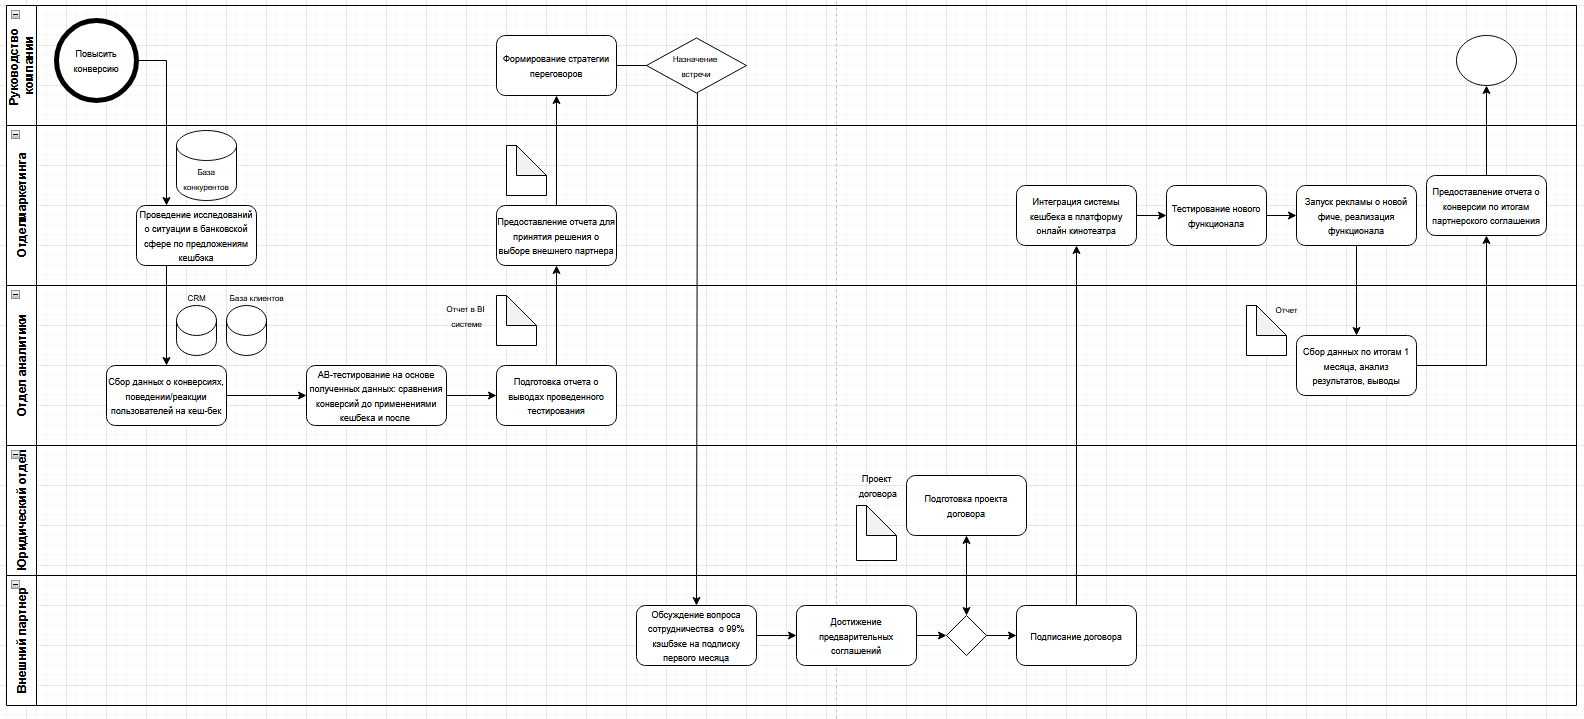

<div class="alert alert-success">
Оригинал draw.io - здесь:<br>
https://drive.google.com/file/d/1_DyumOvhH4Q_EjobHCnBunEYpIYA5oad/view?usp=sharing
</div>